## Tutorial: choice of parametrization

In this tutorial we'll look at several examples of how the choice of parameters to sample with MCMC can affect the resulting posteriors. This task depends heavily on the available data, so we'll only cover some scenarios here.

### The joys of Phoebe

Unlike many other EB modeling codes, which have a fixed set of available parameters, Phoebe offers a wide parameter space to play with, in which (as we have seen in week 1) related parameters are linked through constraints. Constraints can be flipped in any direction to allow for setting (and consequently, fitting) different parameters, while constraining others. Let's remind ourselves of some of the constraints we've used often throughout the tutorials so far:
- q = mass@secondary/mass@primary
- asini@binary = sma@binary * sin(incl@binary)
- requivsumfrac = (requiv@primary + requiv@secondary)/sma@binary
- requivratio = requiv@secondary / requiv@primary
- teffratio = teff@secondary / teff@primary
- esinw = ecc * sin(per0)
- ecosw = ecc * cos(per0)
... and many others

Now let's see how flipping these constraints can help us achieve more robust MCMC posteriors.
In this tutorial, we'll be using a Phoebe bundle in which all parameters are set to their *true values*. This will help us **only explore the effect of different parametrization**. 

In [1]:
import phoebe
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
lc = np.loadtxt('data/synthetic/lc.data')
rv1 = np.loadtxt('data/synthetic/rv1.data')
rv2 = np.loadtxt('data/synthetic/rv2.data')

### Case 1: only a light curve

Let's load the bundle that has all parameters set to their true values. This bundle has no datasets attached to it, so we'll have to add them here, depending on the case we're considering. We'll also set the pblum_mode to dataset-scaled to avoid effects of marginalization over pblum in the light curve.

You can download the bundle here:
[true.bundle](https://github.com/phoebe-project/phoebe2-workshop/raw/2021june/data/synthetic/true.bundle)

100%|████████████████████████████████████████| 200/200 [00:06<00:00, 29.78it/s]


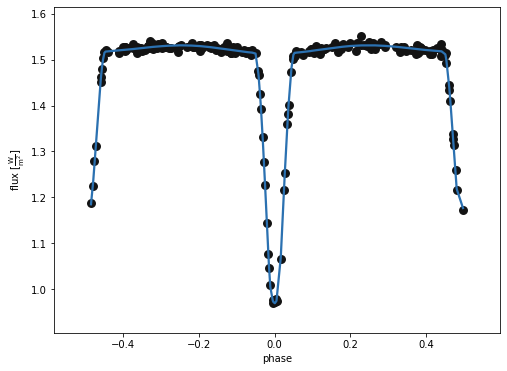

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [3]:
b = phoebe.load('data/synthetic/true.bundle')
b.add_dataset('lc', times=lc[:,0], fluxes=lc[:,1], sigmas=lc[:,2], passband='Johnson:V')
b.set_value_all('pblum_mode', 'dataset-scaled')
b.run_compute()
b.plot(x='phase', show=True)

#### sampling in physical parameters

The bundle is also parameterized in the physical parameters: radii, masses and temperatures. Let's see what happens if we sample in those as opposed to the constraints between them.

Add distributions around the true values:

In [4]:
b.add_distribution({
    'requiv@primary': phoebe.gaussian_around(0.1),
    'requiv@secondary': phoebe.gaussian_around(0.1),
    'mass@primary': phoebe.gaussian_around(0.5),
    'mass@secondary': phoebe.gaussian_around(0.5),
    'teff@primary': phoebe.gaussian_around(250),
    'teff@secondary': phoebe.gaussian_around(250)
}, distribution='physical', overwrite_all=True)

<ParameterSet: 6 parameters | components: secondary, primary>

Lines below this one have been run in advance, to produce sufficient iterations for visualization of the results
_________________________________________

In [5]:
# b.add_server('remoteslurm', crimpl_name='clusty', nprocs=48, walltime=48,
#              use_conda=True, conda_env='phoebe-workshop',
#              server='clusty')

In [6]:
# b.add_solver('sampler.emcee', solver='mcmc_physical',
#               init_from='physical',
#               compute='phoebe01', nwalkers=48, niters=1000, progress_every_niters=50)

In [7]:
# b.run_solver('mcmc_physical', use_server='clusty', solution='mcmc_physical_solution', detach=True)

In [8]:
# b.load_job_progress(solution='mcmc_physical_solution')
# b.save('data/synthetic/true_mcmc_physical.bundle')

______________________________________________________
Let's load the bundle with the solution after 1000 solutions and see how it performed. Keep in mind that all parameters are set to their *true* values and we initialized the MCMC sample *around the true values* of the sampled parameters.

Download bundle: [true_mcmc_physical.bundle](https://github.com/phoebe-project/phoebe2-workshop/raw/2021june/data/synthetic/true_mcmc_physical.bundle)

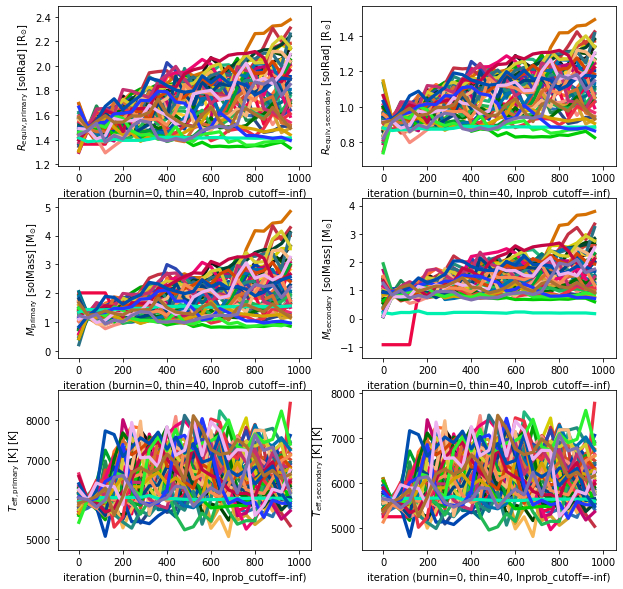

(<autofig.figure.Figure | 6 axes | 288 call(s)>,
 <Figure size 720x720 with 6 Axes>)

In [9]:
b = phoebe.load('data/synthetic/true_mcmc_physical.bundle')
b.plot(solution='mcmc_physical_solution', style='trace', burnin=0, show=True, fig=plt.figure(figsize=(10,10)))

(None, <Figure size 1000.8x1000.8 with 36 Axes>)

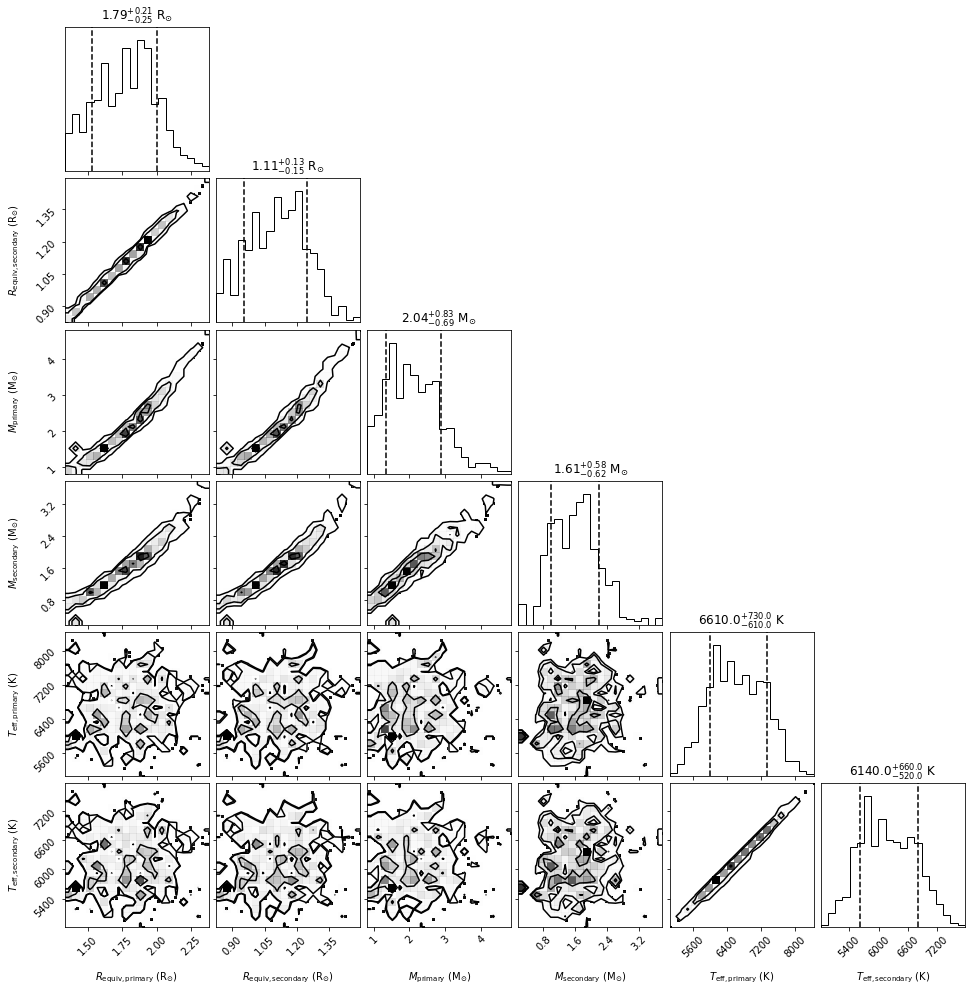

In [10]:
b.plot(solution='mcmc_physical_solution', style='corner', burnin=600, show=True)

So why did we get the kind of posteriors we did in the example above? 

#### sampling in sums and ratios of physical parameters

Let's try sampling the previously constrained parameters instead.

In [11]:
b = phoebe.load('data/synthetic/true.bundle')
b.add_dataset('lc', times=lc[:,0], fluxes=lc[:,1], sigmas=lc[:,2], passband='Johnson:V')
b.set_value('pblum_mode', 'dataset-scaled')

In [12]:
b.flip_constraint('q', solve_for='mass@secondary')
b.flip_constraint('sma@binary', solve_for='mass@primary') # optional since lc also doesn't constrain sma

b.add_constraint('requivsumfrac')
b.add_constraint('requivratio')
b.add_constraint('teffratio')

b.flip_constraint('requivsumfrac', solve_for='requiv@primary@component')
b.flip_constraint('requivratio', solve_for='requiv@secondary@component')
b.flip_constraint('teffratio', solve_for='teff@secondary@component')

<ConstraintParameter: {teff@secondary@component} = {teffratio@binary@component} * {teff@primary@component} (solar units) => 5610.0 K>

In [13]:
b.add_distribution({
    'requivsumfrac': phoebe.gaussian_around(0.01),
    'requivratio': phoebe.gaussian_around(0.1),
    'teffratio': phoebe.gaussian_around(0.1),
    'q': phoebe.gaussian_around(0.1)
}, distribution='sum_ratios', overwrite_all=True)

<ParameterSet: 4 parameters | qualifiers: requivsumfrac, q, teffratio, requivratio>

_________________________________________

In [14]:
# b.add_server('remoteslurm', crimpl_name='clusty', nprocs=48, walltime=48,
#              use_conda=True, conda_env='phoebe-workshop',
#              server='clusty')

In [15]:
# b.add_solver('sampler.emcee', solver='mcmc_sum_ratios',
#               init_from='sum_ratios',
#               compute='phoebe01', nwalkers=48, niters=1000, progress_every_niters=50)

In [16]:
# b.run_solver('mcmc_sum_ratios', use_server='clusty', solution='mcmc_sum_ratios_solution', detach=True)

In [17]:
# b.load_job_progress(solution='mcmc_sum_ratios_solution')
# b.save('data/synthetic/true_mcmc_sum_ratios.bundle')

______________________________________________________

Download the bundle with solution: [true_mcmc_sum_ratios.bundle](https://github.com/phoebe-project/phoebe2-workshop/raw/2021june/data/synthetic/true_mcmc_sum_ratios.bundle)

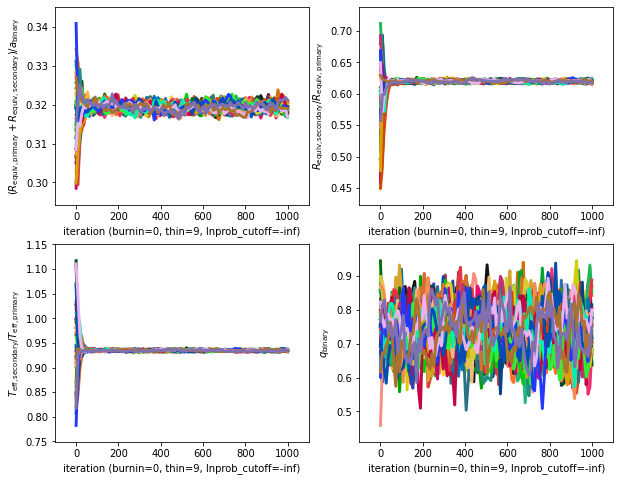

(<autofig.figure.Figure | 4 axes | 192 call(s)>,
 <Figure size 720x576 with 4 Axes>)

In [18]:
b = phoebe.load('data/synthetic/true_mcmc_sum_ratios.bundle')
b.plot(solution='mcmc_sum_ratios_solution', style='trace', burnin=0, show=True, fig=plt.figure(figsize=(10,8)))

(None, <Figure size 698.4x698.4 with 16 Axes>)

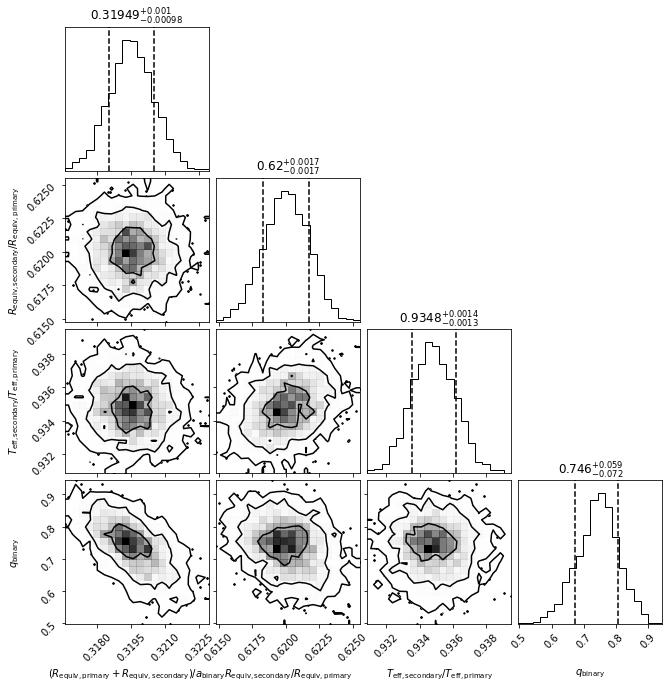

In [19]:
b.plot(solution='mcmc_sum_ratios_solution', style='corner', burnin=500, show=True)

### Case 2: Only a primary RV

We've already seen that the light curve doesn't constrain well the physical parameters. It's similar for the RVs, which are defined in terms of the Keplerian orbit and sensitive mainly to q, sma, vgamma, ecc and per0. But complications arise when we have only one RV. 

Let's see what happens when we sample for q, sma@binary and vgamma and only have a primary RV.

100%|████████████████████████████████████████| 199/199 [00:06<00:00, 29.87it/s]


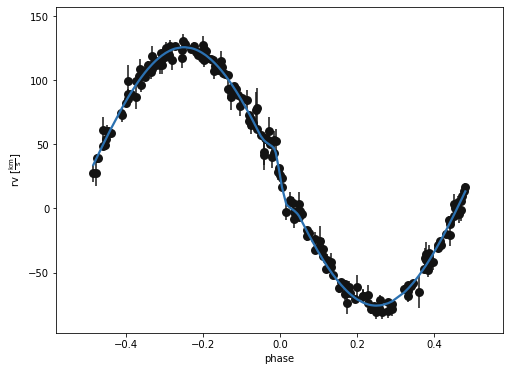

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [20]:
b = phoebe.load('data/synthetic/true.bundle')
b.add_dataset('rv', component='primary', times=rv1[:,0], rvs=rv1[:,1], sigmas=rv1[:,2])
b.run_compute()
b.plot(x='phase', show=True)

In [21]:
b.flip_constraint('q', solve_for='mass@secondary')
b.flip_constraint('sma@binary', solve_for='mass@primary')

<ConstraintParameter: {mass@primary@component} = (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ({q@binary@component} + 1.000000)) * 2942.206217504419328179210424423218) (solar units) => 1.1999999999999995 solMass>

In [22]:
b.add_distribution(
    {'q': phoebe.gaussian_around(0.1),
        'vgamma': phoebe.gaussian_around(1),
        'sma@binary': phoebe.gaussian_around(0.5)
    },
    distribution='dist_rv1')

<ParameterSet: 3 parameters | qualifiers: sma, q, vgamma>

In [23]:
# b.add_server('remoteslurm', crimpl_name='clusty', nprocs=48, walltime=48,
#              use_conda=True, conda_env='phoebe-workshop',
#              server='clusty')

In [24]:
# b.add_solver('sampler.emcee', solver='mcmc_rv1',
#               init_from='dist_rv1',
#               compute='phoebe01', nwalkers=48, niters=500, progress_every_niters=50)

In [25]:
# b.run_solver('mcmc_rv1', use_server='clusty', solution='mcmc_rv1_solution', detach=True)

### Case 3: Both RVs

We already saw in the previous tutorial that this case constrains all of the RV-related parameters. Let's sample again for q, vgamma and sma@binary starting from the true values (to compare the solution with the one RV case).

100%|████████████████████████████████████████| 199/199 [00:06<00:00, 29.66it/s]
/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


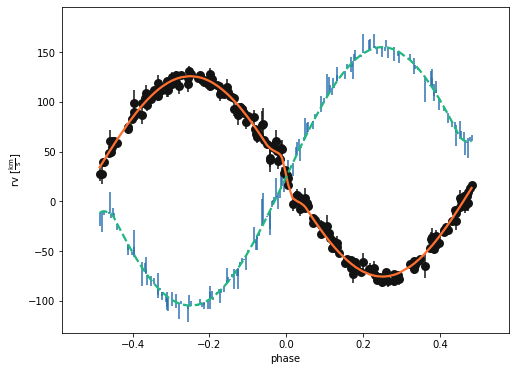

(<autofig.figure.Figure | 1 axes | 4 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [26]:
b.set_value('times', component='secondary', dataset='rv01', value=rv2[:,0])
b.set_value('rvs', component='secondary', dataset='rv01', value=rv2[:,1])
b.set_value('sigmas', component='secondary', dataset='rv01', value=rv2[:,2])
b.run_compute()
b.plot(x='phase', show=True)

In [27]:
# b.add_solver('sampler.emcee', solver='mcmc_rvs',
#               init_from='dist_rv1',
#               compute='phoebe01', nwalkers=48, niters=500, progress_every_niters=50)

In [28]:
# b.run_solver('mcmc_rvs', use_server='clusty', solution='mcmc_rvs_solution', detach=True)

In [29]:
# b.save('data/synthetic/true_mcmc_rvs.bundle')

In [30]:
# b = phoebe.load('data/synthetic/true_mcmc_rvs.bundle')
# b.load_job_progress(solution='mcmc_rv1_solution')
# b.load_job_progress(solution='mcmc_rvs_solution')
# b.save('data/synthetic/true_mcmc_rvs.bundle')

Download the bundle with RV solutions: [true_mcmc_rvs.bundle](https://github.com/phoebe-project/phoebe2-workshop/raw/2021june/data/synthetic/true_mcmc_rvs.bundle)

In [31]:
b = phoebe.load('data/synthetic/true_mcmc_rvs.bundle')

Posteriors with one RV:

(None, <Figure size 547.2x547.2 with 9 Axes>)

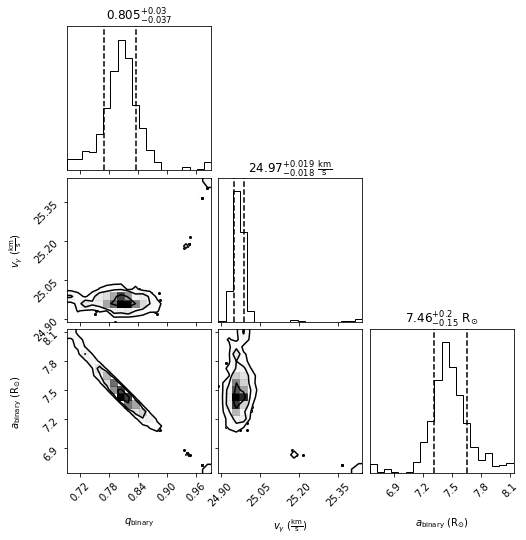

In [32]:
b.plot(solution='mcmc_rv1_solution', style='corner', burnin=250, show=True)

Posteriors with both RVs:

(None, <Figure size 547.2x547.2 with 9 Axes>)

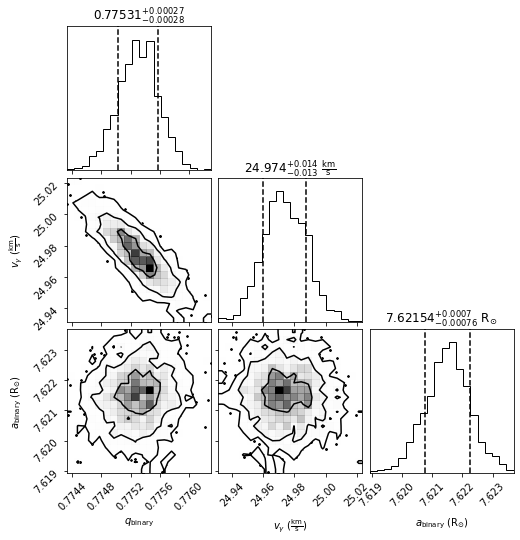

In [33]:
b.plot(solution='mcmc_rvs_solution', style='corner', burnin=250, show=True)

### Exercises

*For the exercises below, setup and submit jobs on terra. You can come back to the results and analyze them later if they take longer to converge. Setting the distorion method to spherical, the rv method to dynamical and disabling irradiation will also help speed up these computations. Running for several hundred iterations should be enough.*

**Exercise 1**. Try sampling for ecc/per0 vs esinw/ecosw on the light curve only (while keeping the other parameters at their true values). Is there a difference in the resulting posteriors? Which choice of parameters would you say is better constrained by the light curve?

**Exercise 2**. Can you think of a better parameter to sample for instead of sma@binary in the one RV case?

**Exercise 3**. Try the physical parameter vs. sum/ratios sampling using all available data. What's different when we add the RVs?

**Exercise 4.**: Use the physical parameters distribution and propagate them to get distributions on requivsumfrac, requivratio, q and teffratio. How do they compare to the results when we directly sample them?